# CNN + Batch Normalization + Dropout

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import torchvision
import tqdm
%matplotlib inline

seaborn.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

### データの読み込み

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

# 画像を読み込んだ時の変換関数を作る
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0,), (1,)),
                         ])
# それぞれのデータと読み込み方を指定
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=2)


#### GPU が使えるなら使う

In [0]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

### ネットワークを作る

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Customconv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, batch_norm=True, dropout_rate=0.5):
        super().__init__()
        self.batch_norm = batch_norm
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)  # This is also learnable by default. See https://pytorch.org/docs/stable/nn.html#batchnorm2d.
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.batch_norm:
            x = self.norm(x)
        x = self.dropout(x)
        return x


class Customlinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, batch_norm=True, dropout_rate=0.5):
        super().__init__()
        self.batch_norm = batch_norm
        self.fc = nn.Linear(in_features, out_features, bias)
        self.norm = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        if self.batch_norm:
            x = self.norm(x)
        x = self.dropout(x)
        return x

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() # super の第一引数はこのクラスの名前にする
        self.convs = nn.Sequential(
            Customconv(1, 4, 5, padding=2),  # 1*28*28 -> 4*28*28
            Customconv(4, 16, 5,padding=2), # 4*28*28 -> 16*28*28
            Customconv(16, 64, 5, stride=2, padding=2), # 16*28*28 -> 64*14*14
            Customconv(64, 32, 3),     # 64*14*14 -> 32*12*12
            Customconv(32, 16, 3, stride=2)  # 32*12*12 -> 16*5*5
        )

        self.fcs = nn.Sequential(
            Customlinear(16*5*5, 200),          # 16*5*5 -> 200
            Customlinear(200, 200),
            Customlinear(200, 50),
            Customlinear(50, 20),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 5*5*16)
        x = self.fcs(x)
        return x
    

net = Net()
net = try_gpu(net)
print(net)

Net(
  (convs): Sequential(
    (0): Customconv(
      (conv): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): Customconv(
      (conv): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): Customconv(
      (conv): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (3): Customconv(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

### 損失関数と最適化手法の定義

In [0]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005) # 微分の"使い方"

### 学習する

1 epoch /  100 roop  loss: 2.333
1 epoch /  200 roop  loss: 2.222
1 epoch /  300 roop  loss: 2.005
1 epoch /  400 roop  loss: 1.728
1 epoch /  500 roop  loss: 1.531
1 epoch /  600 roop  loss: 1.373
2 epoch /  100 roop  loss: 1.271
2 epoch /  200 roop  loss: 1.219
2 epoch /  300 roop  loss: 1.158
2 epoch /  400 roop  loss: 1.085
2 epoch /  500 roop  loss: 1.058
2 epoch /  600 roop  loss: 1.013
3 epoch /  100 roop  loss: 1.002
3 epoch /  200 roop  loss: 0.987
3 epoch /  300 roop  loss: 0.967
3 epoch /  400 roop  loss: 0.989
3 epoch /  500 roop  loss: 0.973
3 epoch /  600 roop  loss: 0.928
4 epoch /  100 roop  loss: 0.938
4 epoch /  200 roop  loss: 0.907
4 epoch /  300 roop  loss: 0.917
4 epoch /  400 roop  loss: 0.888
4 epoch /  500 roop  loss: 0.915
4 epoch /  600 roop  loss: 0.896
5 epoch /  100 roop  loss: 0.877
5 epoch /  200 roop  loss: 0.880
5 epoch /  300 roop  loss: 0.877
5 epoch /  400 roop  loss: 0.877
5 epoch /  500 roop  loss: 0.835
5 epoch /  600 roop  loss: 0.855
6 epoch / 

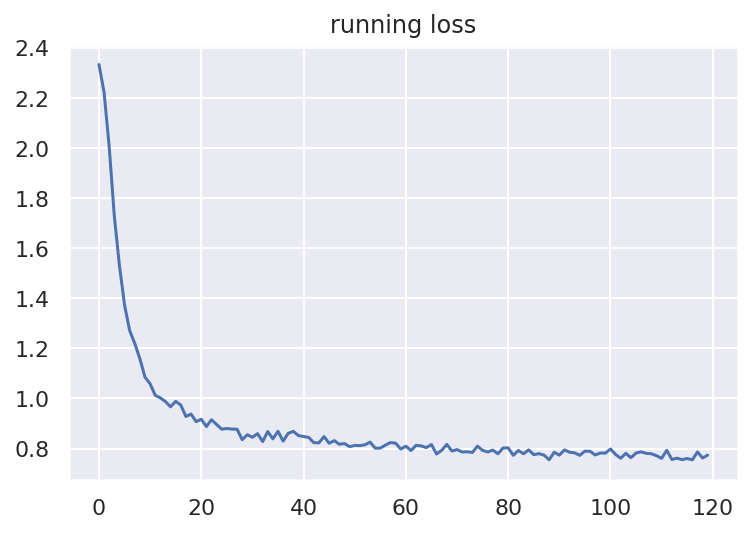

CPU times: user 3min 10s, sys: 5.69 s, total: 3min 16s
Wall time: 4min 9s


In [6]:
%%time
net.train()
running_losses = list()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=1): 
        # get the inputs
        inputs, labels = data
        inputs = try_gpu(inputs)
        labels = try_gpu(labels)

        # 計算していた逆伝播を0に戻す
        optimizer.zero_grad()

        # forward / backward / optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # データを損失関数に突っ込む
        loss.backward()    # 誤差逆伝播(パラメータの変化の微分を計算)
        optimizer.step()   # 最適化手法をもとにパラメータ更新

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 200 mini-batches (1バッチは100枚 trainデータは60000枚あるので600までいく)
            running_loss_mean = running_loss / 100
            print('%d epoch /%5d roop  loss: %.3f' %
                  (epoch + 1, i, running_loss_mean), flush=True)
            running_losses.append(running_loss_mean)
            running_loss = 0.0


print('Finished Training')

plt.plot(running_losses)
plt.title("running loss")
plt.show()

### 個別にテスト

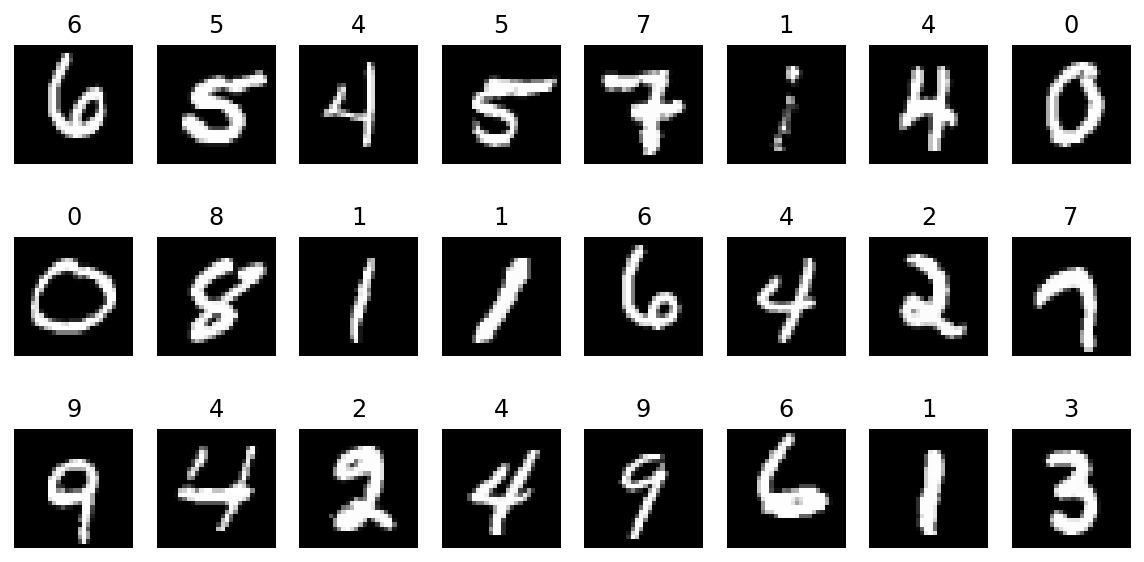

In [7]:
net.eval()
each_testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)


dataiter = iter(each_testloader) 
plt.figure(figsize=(10,5))
with torch.no_grad(): # 学習のときのようなバックグラウンドでの勾配計算は不要なのでしない
    for epoch in range(3*8):
        image, label = dataiter.next() # each_testloader はバッチサイズを１にしたので1枚ずつ出てくる
        image, label = try_gpu(image), try_gpu(label)
        output = net(image)
        _, predicted = torch.max(output, 1)
        predicted = predicted.item() # tensor(pytorchでのデータ型)をpythonの数に直す
        image = image.cpu().reshape(28, 28) 
        label = label.item() 
        plt.subplot(3, 8, epoch+1)
        plt.axis("off")
        plt.imshow(image, cmap='gray')
        if predicted == label:
            plt.title(predicted, color='black')
        else:
            plt.title(predicted, color='red')
   
    plt.show()


### 正解率を出す

In [8]:
%%time
net.eval()
with torch.no_grad(): # 学習のときのようなバックグラウンドでの勾配計算は不要なのでしない
    for txt, loader in zip(('Train', 'Test '), (trainloader, testloader)):
        correct = 0
        total = 0
        for data in loader:
            images, labels = data
            images, labels = try_gpu(images), try_gpu(labels)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'{txt} Accuracy: {100 * correct / total} %')

Train Accuracy: 98.54666666666667 %
Test  Accuracy: 98.62 %
CPU times: user 2.61 s, sys: 349 ms, total: 2.96 s
Wall time: 10.1 s
